#  Imports & Configuration

In [ ]:
# MODULE 0: Imports & Configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import os
from PIL import Image
import warnings

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

# Paths
DATA_PATH = Path("../data")
PROCESSED_PATH = DATA_PATH / "processed/metadata"

# Image Configuration
IMG_SIZE = 224  # Standard size for pretrained models
BATCH_SIZE = 32
NUM_CLASSES = 15

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

In [28]:
# MODULE 1: Load Preprocessed Data from Week 1

def load_preprocessed_data():
    """
    Load the train/val/test splits created in Week 1
    """
    train_df = pd.read_csv(PROCESSED_PATH / "nih_train_data.csv")
    val_df = pd.read_csv(PROCESSED_PATH / "nih_val_data.csv")
    test_df = pd.read_csv(PROCESSED_PATH / "nih_test_data.csv")
    
    print(f"Train samples: {len(train_df):,}")
    print(f"Validation samples: {len(val_df):,}")
    print(f"Test samples: {len(test_df):,}")
    
    return train_df, val_df, test_df

# Load the data
train_df, val_df, test_df = load_preprocessed_data()

# Get label columns (all columns except metadata)
LABEL_COLUMNS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
                 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 
                 'Infiltration', 'Mass', 'No Finding', 'Nodule', 
                 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

print(f"\nNumber of disease labels: {len(LABEL_COLUMNS)}")
print(f"\nFirst few rows of training data:")
train_df.head()

Train samples: 69,219
Validation samples: 17,305
Test samples: 25,596

Number of disease labels: 15

First few rows of training data:


,Image Index,Finding Labels,full_path,num_labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00028324_001.png,Mass|Pleural_Thickening,E:\archive\images_012\images\00028324_001.png,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,00006949_004.png,No Finding,E:\archive\images_004\images\00006949_004.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,00003923_000.png,Atelectasis,E:\archive\images_002\images\00003923_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00017365_002.png,No Finding,E:\archive\images_008\images\00017365_002.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00018947_001.png,No Finding,E:\archive\images_009\images\00018947_001.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [30]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image for visualization or model input.
    
    Args:
        image_path: Path to the image file
        target_size: Tuple of (height, width) to resize the image
    
    Returns:
        Preprocessed image as numpy array, or None if loading fails
    """
    try:
        # Load image
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Warning: Could not load image at {image_path}")
            return None
        
        # Convert BGR to RGB (OpenCV loads as BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        img = cv2.resize(img, target_size)
        
        # Normalize to [0, 1] range for visualization
        img = img.astype(np.float32) / 255.0
        
        return img
        
    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return None

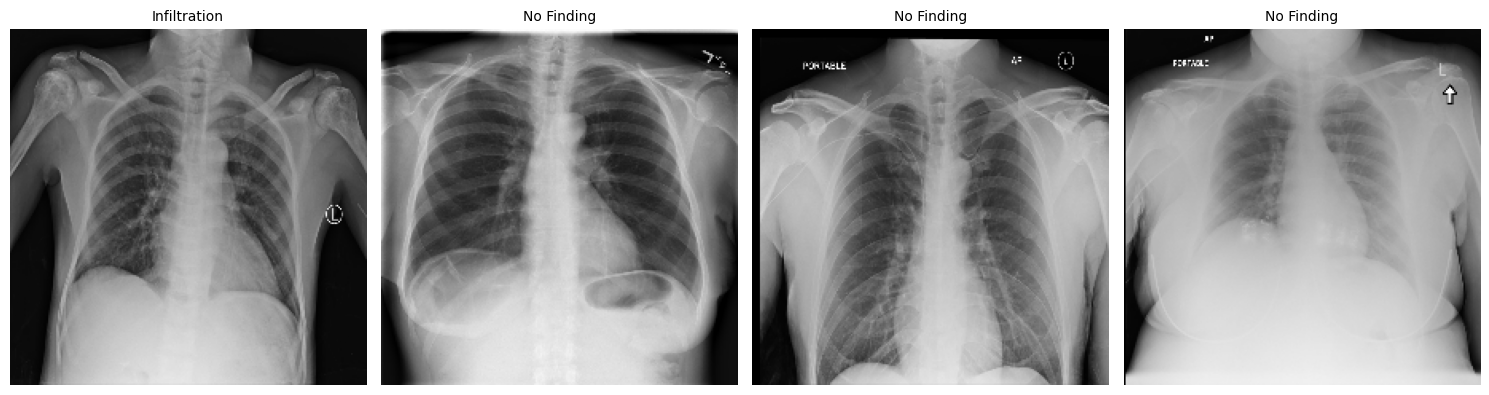

✓ Sample images saved to: ../results/plots/sample_images.png


In [31]:
# MODULE 2 (continued): Visualize Sample Images

def visualize_sample_images(df, num_samples=4):
    """
    Visualize some sample images from the dataset
    """
    samples = df.sample(n=num_samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        img = load_and_preprocess_image(row['full_path'])
        
        if img is not None:
            axes[idx].imshow(img)
            # Truncate long labels
            label_text = row['Finding Labels'][:30]
            if len(row['Finding Labels']) > 30:
                label_text += "..."
            axes[idx].set_title(label_text, fontsize=10)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/plots/sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Sample images saved to: ../results/plots/sample_images.png")


# Visualize some samples
visualize_sample_images(train_df, num_samples=4)

In [32]:
# MODULE 3: Data Augmentation Configuration

def create_data_generators():
    """
    Create ImageDataGenerator for training (with augmentation) and validation/test (without)
    
    Training augmentations:
    - Random rotation (±10 degrees)
    - Random horizontal flip
    - Random zoom (±10%)
    - Random shift (10%)
    """
    
    # Training generator WITH augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=10,           # Rotate images randomly by 10 degrees
        width_shift_range=0.1,       # Shift images horizontally by 10%
        height_shift_range=0.1,      # Shift images vertically by 10%
        zoom_range=0.1,              # Zoom in/out by 10%
        horizontal_flip=True,        # Randomly flip images horizontally
        fill_mode='nearest'          # Fill empty pixels with nearest value
    )
    
    # Validation and Test generators WITHOUT augmentation
    val_test_datagen = ImageDataGenerator()
    
    print("✓ Data generators created:")
    print("  - Training: WITH augmentation")
    print("  - Validation/Test: WITHOUT augmentation")
    
    return train_datagen, val_test_datagen


# Create generators
train_datagen, val_test_datagen = create_data_generators()

✓ Data generators created:
  - Training: WITH augmentation
  - Validation/Test: WITHOUT augmentation


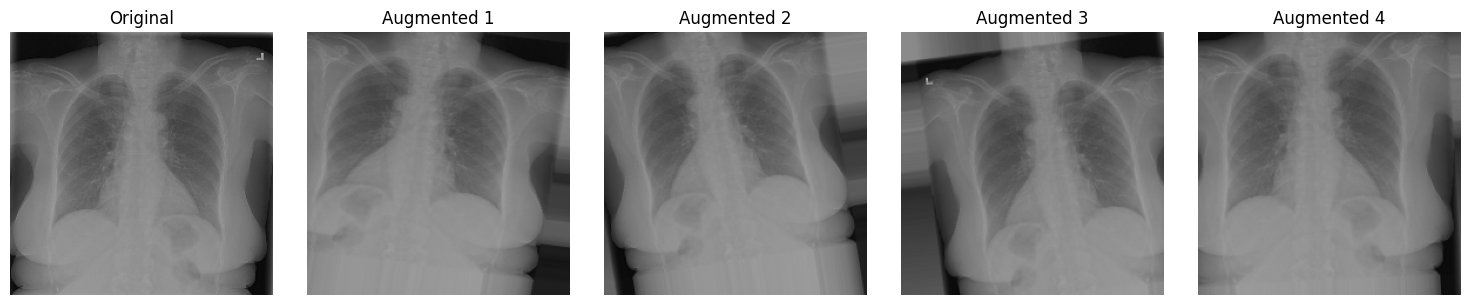

✓ Augmentation examples saved to: ../results/plots/augmentation_examples.png


In [34]:
# MODULE 3 (continued): Visualize Augmentations

def visualize_augmentations(df, num_samples=5):
    """
    Show original image vs augmented versions
    """
    sample = df.iloc[0]
    img = load_and_preprocess_image(sample['full_path'])
    
    if img is None:
        print("Could not load image for augmentation visualization")
        return
    
    # Create augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Reshape for augmentation
    img_reshaped = img.reshape((1,) + img.shape)
    
    # Generate augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Generate augmented versions
    i = 1
    for batch in datagen.flow(img_reshaped, batch_size=1):
        axes[i].imshow(batch[0])
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')
        i += 1
        if i >= num_samples:
            break
    
    plt.tight_layout()
    plt.savefig('../results/plots/augmentation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Augmentation examples saved to: ../results/plots/augmentation_examples.png")


# Visualize augmentations
visualize_augmentations(train_df)

In [49]:
class ChestXrayGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, img_size=224, shuffle=True, augment=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indices]
        
        X = np.zeros((len(batch_data), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_data), len(LABEL_COLUMNS)), dtype=np.float32)
        
        successful_loads = 0
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            try:
                img_path = row['full_path']
                
                # Check if file exists
                if not os.path.exists(img_path):
                    print(f"File not found: {img_path}")
                    continue
                
                # Load image
                img = cv2.imread(img_path)
                
                if img is None:
                    print(f"cv2.imread returned None for: {img_path}")
                    continue
                
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Resize - CRITICAL FIX: Must be tuple of integers
                target_size = (int(self.img_size), int(self.img_size))
                img = cv2.resize(img, target_size)
                
                # Normalize
                img = img.astype(np.float32) / 255.0
                
                # Apply augmentation if enabled
                if self.augment:
                    img = self.apply_augmentation(img)
                
                X[i] = img
                y[i] = row[LABEL_COLUMNS].values
                successful_loads += 1
                
            except Exception as e:
                print(f"Error loading {row['full_path']}: {str(e)}")
                continue
        
        if successful_loads == 0:
            print(f"WARNING: No images loaded successfully in batch {index}!")
        
        return X, y
    
    def apply_augmentation(self, img):
        """Apply random augmentations"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.fliplr(img)
        
        # Random rotation
        if np.random.random() > 0.5:
            angle = np.random.uniform(-15, 15)
            h, w = img.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        
        # Random brightness
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.8, 1.2)
            img = np.clip(img * factor, 0, 1)
        
        return img
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# Recreate generators with the fixed class
print("Recreating generators with fixes...")

train_generator = ChestXrayGenerator(
    train_df, 
    batch_size=32, 
    img_size=224, 
    shuffle=True, 
    augment=True
)

val_generator = ChestXrayGenerator(
    val_df, 
    batch_size=32, 
    img_size=224, 
    shuffle=False, 
    augment=False
)

test_generator = ChestXrayGenerator(
    test_df, 
    batch_size=32, 
    img_size=224, 
    shuffle=False, 
    augment=False
)

print(f"✓ Generators recreated successfully!")

Recreating generators with fixes...
✓ Generators recreated successfully!


In [50]:
# Test loading a single image to diagnose the issue
def test_single_image_load(df, num_tests=5):
    """Test loading individual images to diagnose issues"""
    print("\n" + "="*60)
    print("TESTING IMAGE LOADING")
    print("="*60)
    
    for i in range(min(num_tests, len(df))):
        row = df.iloc[i]
        img_path = row['full_path']
        
        print(f"\nTest {i+1}:")
        print(f"  Path: {img_path}")
        print(f"  Exists: {os.path.exists(img_path)}")
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                print(f"  ✓ Loaded successfully!")
                print(f"  Shape: {img.shape}")
                print(f"  Min/Max values: {img.min()}/{img.max()}")
                
                # Try resizing
                try:
                    img_resized = cv2.resize(img, (224, 224))
                    print(f"  ✓ Resize successful: {img_resized.shape}")
                except Exception as e:
                    print(f"  ✗ Resize failed: {e}")
            else:
                print(f"  ✗ cv2.imread returned None")
        else:
            print(f"  ✗ File does not exist")

# Run the test
test_single_image_load(train_df)


TESTING IMAGE LOADING

Test 1:
  Path: E:\archive\images_012\images\00028324_001.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 3/252
  ✓ Resize successful: (224, 224, 3)

Test 2:
  Path: E:\archive\images_004\images\00006949_004.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 0/229
  ✓ Resize successful: (224, 224, 3)

Test 3:
  Path: E:\archive\images_002\images\00003923_000.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 0/253
  ✓ Resize successful: (224, 224, 3)

Test 4:
  Path: E:\archive\images_008\images\00017365_002.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 0/255
  ✓ Resize successful: (224, 224, 3)

Test 5:
  Path: E:\archive\images_009\images\00018947_001.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 0/255
  ✓ Resize successful: (224, 224, 3)


In [47]:
4

print(f'  Train batches: {len(train_generator)}')
print(f'  Validation batches: {len(val_generator)}')
print(f'  Test batches: {len(test_generator)}')

  Train batches: 2164
  Validation batches: 541
  Test batches: 800



TESTING IMAGE LOADING

Test 1:
  Path: E:\archive\images_012\images\00028324_001.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 3/252
  ✓ Resize successful: (224, 224, 3)

Test 2:
  Path: E:\archive\images_004\images\00006949_004.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 0/229
  ✓ Resize successful: (224, 224, 3)

Test 3:
  Path: E:\archive\images_002\images\00003923_000.png
  Exists: True
  ✓ Loaded successfully!
  Shape: (1024, 1024, 3)
  Min/Max values: 0/253
  ✓ Resize successful: (224, 224, 3)

VISUALIZING BATCH

Attempting to load batch from generator...
Batch loaded: X shape=(32, 224, 224, 3), y shape=(32, 15)
X min/max: 0.0000/1.0000
Non-zero images: 32/32


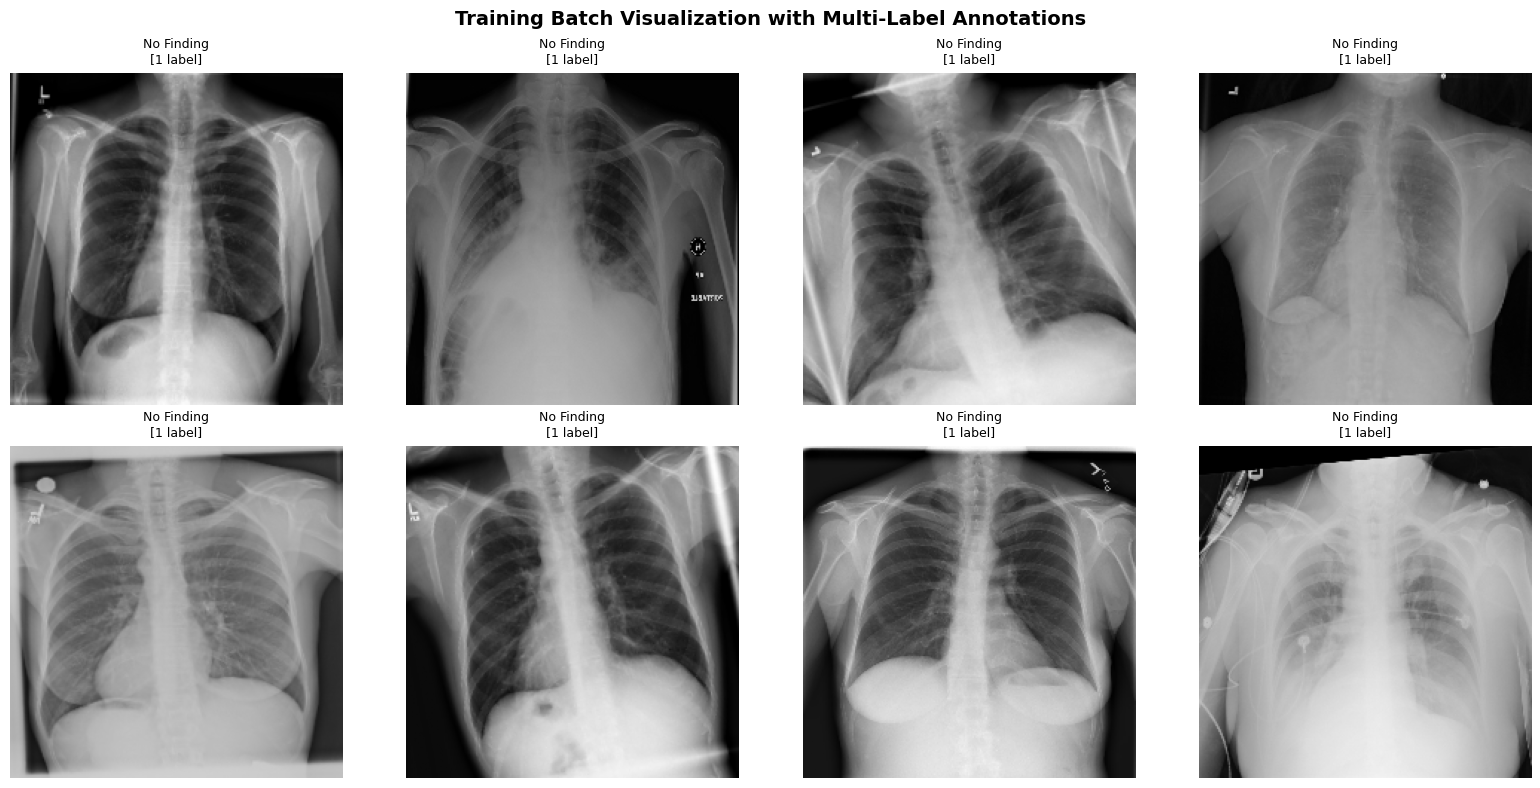

✓ Visualization complete and saved to: ../results/plots/batch_visualization.png


In [51]:
def visualize_batch_v2(generator, num_images=8, save_path='../results/plots/batch_visualization.png'):
    """
    Visualize images from one batch with better error checking.
    """
    try:
        print(f"\nAttempting to load batch from generator...")
        
        # Get one batch
        X_batch, y_batch = generator[0]
        
        print(f"Batch loaded: X shape={X_batch.shape}, y shape={y_batch.shape}")
        print(f"X min/max: {X_batch.min():.4f}/{X_batch.max():.4f}")
        
        # Check if images are all black (zeros)
        if X_batch.max() == 0:
            print("⚠️  WARNING: All images are black (zeros)! Images failed to load.")
            return
        
        # Count non-zero images
        non_zero_images = np.sum(X_batch.max(axis=(1,2,3)) > 0)
        print(f"Non-zero images: {non_zero_images}/{len(X_batch)}")
        
        num_images = min(num_images, len(X_batch))
        cols = 4
        rows = (num_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
        
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        for i in range(num_images):
            img = X_batch[i]
            
            # Check if image is valid
            if img.max() == 0:
                axes[i].text(0.5, 0.5, 'Failed to load', 
                           ha='center', va='center', fontsize=12, color='red')
                axes[i].set_facecolor('black')
            else:
                img = np.clip(img, 0, 1)
                axes[i].imshow(img)
            
            # Get labels
            labels = [LABEL_COLUMNS[j] for j in range(len(LABEL_COLUMNS)) 
                     if y_batch[i][j] == 1]
            
            if len(labels) == 0:
                label_str = 'No labels'
            elif len(labels) <= 3:
                label_str = ', '.join(labels)
            else:
                label_str = ', '.join(labels[:3]) + f'\n(+{len(labels)-3} more)'
            
            label_count = f"[{len(labels)} label{'s' if len(labels) != 1 else ''}]"
            axes[i].set_title(f"{label_str}\n{label_count}", fontsize=9, pad=8)
            axes[i].axis('off')
        
        for i in range(num_images, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Training Batch Visualization with Multi-Label Annotations', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Visualization complete and saved to: {save_path}")
        
    except Exception as e:
        print(f"✗ Error visualizing batch: {str(e)}")
        import traceback
        traceback.print_exc()


# Run tests and visualization
test_single_image_load(train_df, num_tests=3)
print("\n" + "="*60)
print("VISUALIZING BATCH")
print("="*60)
visualize_batch_v2(train_generator, num_images=8)